In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt

## Import all data

#### Twitter

In [2]:
twitter_depressed = pd.read_pickle("../twitter_depressed.pickle")
twitter_not_depressed = pd.read_pickle("../twitter_not_depressed.pickle")

In [3]:
negative = twitter_not_depressed[twitter_not_depressed['target']==0]
positive = twitter_not_depressed[twitter_not_depressed['target']==4]

In [4]:
# sentiment 140 negative
negative = negative[['tokenized_text', 'target']]
# sentiment 140 positive
positive = positive[['tokenized_text', 'target']]
# real depressed twitter
twitter_depressed = twitter_depressed[['tokenized_text', 'target']]

In [9]:
negative.head()

tokenized_text  target
0  [awww, bummer, you, shoulda, got, david, carr,...       0
1  [upset, he, update, his, facebook, texting, it...       0
2  [i, dived, many, times, ball, managed, save, r...       0
3   [my, whole, body, feels, itchy, like, its, fire]       0
4                    [behaving, mad, i, i, see, you]       0

In [10]:
positive.head()

tokenized_text  target
800000                        [i, love, u, guys, r, best]       4
800001  [im, meeting, one, my, besties, tonight, cant,...       4
800002  [thanks, twitter, add, sunisa, i, got, meet, y...       4
800003  [sick, really, cheap, it, hurts, much, eat, re...       4
800004                             [he, effect, everyone]       4

In [11]:
twitter_depressed.head()

tokenized_text  target
8000  [lack, understanding, small, significant, part...       1
8001  [i, told, my, parents, my, depression, hard, g...       1
8002  [depression, something, i, speak, even, going,...       1
8003  [made, myself, tortilla, filled, pb, j, my, de...       1
8004  [i, gonna, need, depression, meds, soon, raino...       1

In [12]:
print(f'Length of the preprocessed twitter with negative post {negative.shape[0]}')
print(f'Length of the preprocessed twitter with positive post {positive.shape[0]}')
print(f'Length of the preprocessed twitter with real depressed post {twitter_depressed.shape[0]}')

Length of the preprocessed twitter with negative post 800000
Length of the preprocessed twitter with positive post 800000
Length of the preprocessed twitter with real depressed post 2313


Twitter depressed: https://github.com/viritaromero/Detecting-Depression-in-Tweets/blob/master/sentiment_tweets3.csv

#### Subreddit

In [5]:
subreddit = pd.read_pickle('../depression_tokenized.pickle')

In [6]:
subreddit = subreddit[['tokenized_text']]
subreddit['target']=1

In [15]:
subreddit.head()

tokenized_text  target
0  [many, kinds, therapists, choose, pretty, simp...       1
2  [tired, rejection, i, never, real, girlfriend,...       1
3  [everyone, thinks, i, fine, i, close, i, reall...       1
4  [honesty, i, drink, nights, i, unhappy, i, unh...       1
5  [my, mom, pressuring, me, stop, bad, attitude,...       1

In [16]:
print(f'Length of the preprocessed twitter with depressed post {subreddit.shape[0]}')

Length of the preprocessed twitter with depressed post 840632


#### Combine Data

In [7]:
real_depressed = pd.concat([twitter_depressed, subreddit])
real_depressed.reset_index(inplace = True)
real_depressed.drop(labels='index', axis=1, inplace=True)

In [8]:
negative.reset_index(inplace = True)
negative.drop(labels='index', axis=1, inplace=True)
positive.reset_index(inplace = True)
positive.drop(labels='index', axis=1, inplace=True)

#### Wordcloud Visualisation

In [9]:
real_depressed['sent'] = real_depressed['tokenized_text'].apply(lambda x: " ".join(x))
negative['sent'] = negative['tokenized_text'].apply(lambda x: " ".join(x))
positive['sent'] = positive['tokenized_text'].apply(lambda x: " ".join(x))

In [40]:
def get_word_freq(data):
    cvec = CountVectorizer(stop_words = 'english', max_df=0.9, min_df=5)
    cvec.fit(list(data['sent']))
    doc_matrix = cvec.transform(data['sent'])
    doc_matrix = np.sum(doc_matrix,axis=0)
    doc = np.squeeze(np.asarray(doc_matrix))
    term_freq_df = pd.DataFrame(doc_matrix,
                                columns=cvec.get_feature_names()
                               ).transpose()
    term_freq_df.columns = ['freq']
    term_freq_df = term_freq_df.sort_values(by='freq', ascending = False)[:50]
    return term_freq_df['freq'].to_dict()

def generate_wc(freq_words):
    wc = WordCloud(
        background_color="white",
        max_words=50,
        width = 1024,
        height = 720
    )

    wc = wc.generate_from_frequencies(freq_words)

    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


Positive Sentiment

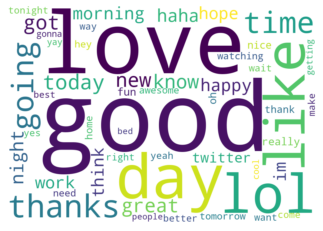

In [41]:
freq_words = get_word_freq(positive)
generate_wc(freq_words)

Negative Sentiment

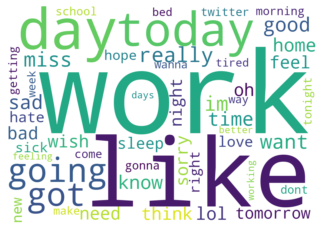

In [42]:
freq_words = get_word_freq(negative)
generate_wc(freq_words)

Depressed post

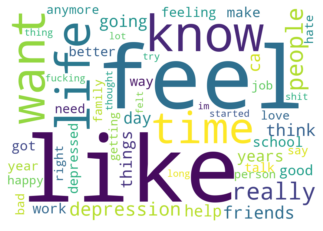

In [43]:
freq_words = get_word_freq(real_depressed)
generate_wc(freq_words)

#### First Method

Remove the negative, as we don't have the ground truth

In [9]:
positive = positive[['tokenized_text', 'target']]
positive['target']=0
real_depressed = real_depressed[['tokenized_text', 'target']]
X_train = pd.concat([positive, real_depressed])
X_train.reset_index(inplace = True)

In [10]:
print('Percentage of each class: ')
print(round((X_train['target'].value_counts()/X_train.shape[0])*100, 2))

Percentage of each class: 
1    51.31
0    48.69
Name: target, dtype: float64


In this case, there are more depressed post compared to the non-depressed post.

In [11]:
y = X_train['target']
X_train = X_train[['tokenized_text']]

In [12]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
sss.get_n_splits(X_train, y)
for train_index, test_index in sss.split(X_train, y):
    X_train, X_test = X_train.loc[train_index, :], X_train.loc[test_index, :]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

In [13]:
print('Percentage of each class in test: ')
print(round((y_test.value_counts()/y_test.shape[0])*100, 2))

Percentage of each class in test: 
1    51.31
0    48.69
Name: target, dtype: float64


By using stratified sample, we attained the exact same distribution for the test data.

In [14]:
X_train['target'] = y_train
X_test['target'] = y_test

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314356 entries, 1039139 to 1026835
Data columns (total 2 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   tokenized_text  1314356 non-null  object
 1   target          1314356 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 30.1+ MB


In [17]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328589 entries, 507332 to 192109
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tokenized_text  328589 non-null  object
 1   target          328589 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.5+ MB


In [20]:
X_train.to_pickle('X_train.pickle')
X_test.to_pickle('X_test.pickle')

#### Second Method (if have time)

In [20]:
twitter_depressed['target']=2
twitter_not_depressed['target']=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
X = pd.concat([twitter_depressed, twitter_not_depressed])
X = pd.concat([X, subreddit])

In [39]:
X.head()

tokenized_text  target
8000  [lack, understanding, small, significant, part...       2
8001  [i, told, my, parents, my, depression, hard, g...       2
8002  [depression, something, i, speak, even, going,...       2
8003  [made, myself, tortilla, filled, pb, j, my, de...       2
8004  [i, gonna, need, depression, meds, soon, raino...       2

In [26]:
print('Percentage of each class: ')
print(round((X['target'].value_counts()/X.shape[0])*100, 2))

Percentage of each class: 
0    65.48
1    34.41
2     0.11
Name: target, dtype: float64


0: Not depressed (Twitter)
1: Depressed (Reddit)
2: Depressed (Twitter)

#### Split into Validation and Test set

In [40]:
X.reset_index(inplace = True)
y = X['target']
X = X[['tokenized_text']]

In [41]:
X.head()

tokenized_text
0  [lack, understanding, small, significant, part...
1  [i, told, my, parents, my, depression, hard, g...
2  [depression, something, i, speak, even, going,...
3  [made, myself, tortilla, filled, pb, j, my, de...
4  [i, gonna, need, depression, meds, soon, raino...

In [43]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

In [49]:
print('Percentage of each class in validation: ')
print(round((y_train.value_counts()/y_train.shape[0])*100, 2))

Percentage of each class in validation: 
0    65.48
1    34.41
2     0.11
Name: target, dtype: float64


In [50]:
print('Percentage of each class in test: ')
print(round((y_test.value_counts()/y_test.shape[0])*100, 2))

Percentage of each class in test: 
0    65.48
1    34.41
2     0.11
Name: target, dtype: float64


Test has the same distribution with the train and validation set.